## Лабораторная работа №3 по курсу "Интеллектуальный анализ данных"

выполнил Сорокин Никита, М8О-403Б-20

## 3.1 Вычисление функций AND, OR и XOR

In [2]:
import numpy as np
import pandas as pd
import torch

from torch import nn
from torch import optim

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Поставим задачу нахождения нейронной сети умеющей классифицировать следующий датасет

In [3]:
n = 10000
X_train = np.random.rand(n, 2)
y_train = [round(x[0]) ^ round(x[1]) for x in X_train]

In [4]:
color_map = np.vectorize(lambda y: 'orange' if y == 0 else 'blue')

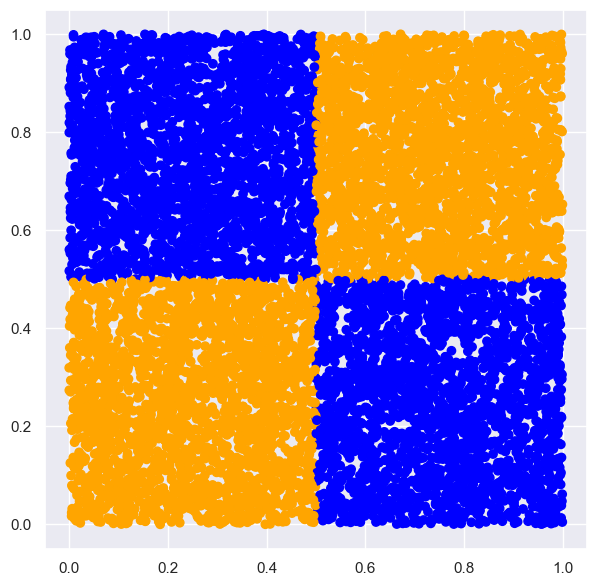

In [5]:
fig, axs = plt.subplots(figsize=(7, 7))
axs.scatter(X_train[:, 0], X_train[:, 1], c=color_map(y_train))

Data: numpy array to tensor

In [6]:
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)

Модель: 3 линейных слоя, функция активации ReLU

In [7]:
model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

In [8]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Обучение и визуализация по ходу обучения:

  0%|          | 0/40 [00:00<?, ?it/s]

 45%|████▌     | 18/40 [00:01<00:00, 26.25it/s]

epoch: 10,	 loss: 0.6720598340034485


 57%|█████▊    | 23/40 [00:01<00:00, 30.27it/s]

epoch: 20,	 loss: 0.6524465084075928


100%|██████████| 40/40 [00:01<00:00, 27.34it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


epoch: 30,	 loss: 0.6256701350212097
epoch: 40,	 loss: 0.5902116298675537


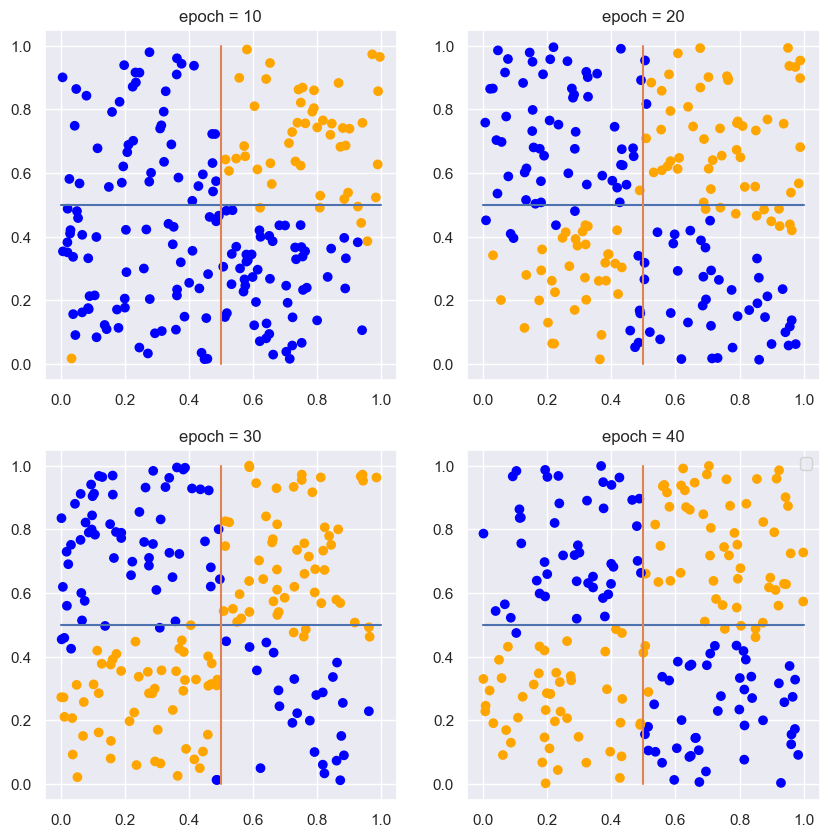

In [9]:
epochs_n = 40

fig, axs = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)

history = []
for epoch in tqdm(range(epochs_n)):
    logits = model(X_train)
    loss = criterion(logits, y_train)
    history.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % (epochs_n // 4) == 0:
        print(f'epoch: {epoch + 1},\t loss: {history[-1]}')
        with torch.no_grad():
            n = 200
            X_val = np.random.rand(n, 2)
            y_val = [round(x[0]) ^ round(x[1]) for x in X_val]

            X_val = torch.FloatTensor(X_val)
            y_val = torch.LongTensor(y_val)

            y_pred = torch.sigmoid(model(X_val))

            X_val = X_val.detach().numpy()
            y_val = y_val.detach().numpy()
            y_pred = y_pred.detach().numpy()

            y_pred = np.argmax(y_pred, axis=1)

        i = 0 if (epoch + 1) <= (epochs_n // 2) else 1
        j = 0 if (epoch + 1) % (epochs_n // 2) == (epochs_n // 4) else 1

        axs[i][j].plot([0, 1], [0.5, 0.5])
        axs[i][j].plot([0.5, 0.5], [0, 1])

        axs[i][j].scatter(X_val[:, 0], X_val[:, 1], c=color_map(y_pred))
        axs[i][j].set_title(f'epoch = {epoch + 1}')

plt.legend()

График обучения

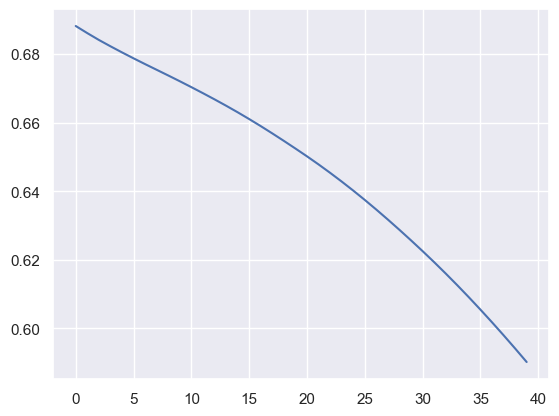

In [10]:
plt.plot(history)

### 3.2 Titanic - Machine Learning from Disaster 

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report

In [50]:
df = pd.read_csv('train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Предобработка данных:

In [51]:
def preprocess_data(df):
    df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
    df = pd.get_dummies(df)
    mean_age = df['Age'].mean()
    print(mean_age)
    df['Age'].fillna(mean_age, inplace=True)

    return df

In [52]:
df_new = preprocess_data(df)
df_new

29.69911764705882


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
0,1,0,3,22.000000,1,0,7.2500,0,1
1,2,1,1,38.000000,1,0,71.2833,1,0
2,3,1,3,26.000000,0,0,7.9250,1,0
3,4,1,1,35.000000,1,0,53.1000,1,0
4,5,0,3,35.000000,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0,1
887,888,1,1,19.000000,0,0,30.0000,1,0
888,889,0,3,29.699118,1,2,23.4500,1,0
889,890,1,1,26.000000,0,0,30.0000,0,1


In [53]:
X_train, X_val, y_train, y_val = train_test_split(df_new.iloc[:, 2:], df_new.iloc[:, 1], random_state=17)

In [54]:
X_train = torch.FloatTensor(X_train.to_numpy())
X_val = torch.FloatTensor(X_val.to_numpy())
y_train = torch.LongTensor(y_train.to_numpy())
y_val = torch.LongTensor(y_val.to_numpy())

In [55]:
in_features = 7
out_features = 2

Модель: 2 линейных слоя по 128 нейронов, функция активации ReLU

In [56]:
model = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.ReLU(),
    nn.Linear(128, out_features)
)

In [57]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Обучение:

In [58]:
epochs_n = 10000

history = []
for epoch in tqdm(range(epochs_n)):
    logits = model(X_train)
    loss = criterion(logits, y_train)
    history.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 10000/10000 [00:27<00:00, 361.99it/s]


График обучения:

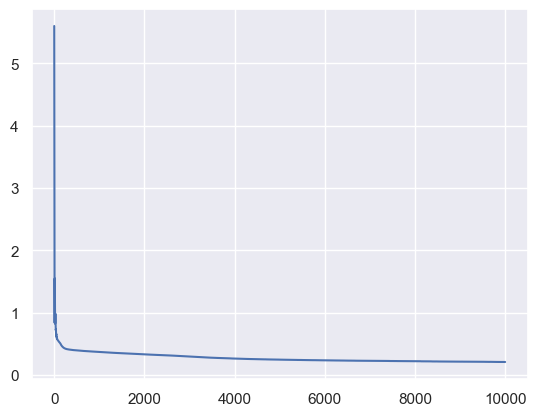

In [59]:
plt.plot(history)

In [60]:
y_pred = torch.sigmoid(model(X_val))
y_pred = y_pred.detach().numpy()
y_pred = np.argmax(y_pred, axis=1)

y_val = y_val.detach().numpy()

Полученные метрики:

In [61]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       131
           1       0.77      0.75      0.76        92

    accuracy                           0.80       223
   macro avg       0.80      0.79      0.80       223
weighted avg       0.80      0.80      0.80       223

